This notebook is optimized for Google Colab.
I prefer if you upload it to colab and run it.

However, to run this locally, be sure you:
-  have python running locally, update the library install format from `!` to `%` so for example `!pip install foo` becomes `%pip install foo`
- store secrets as env variables in your local system using `os.environ.get("SECRET_NAME")` vs what I've currently implemtented



Libraries

In [ ]:
!pip install ragas deepeval datasets

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from ragas.metrics import context_recall, context_precision
from ragas import evaluate
from google.colab import userdata

LLM Stuff

In [27]:
openai_api_key = userdata.get('OPENAI_KEY')
os.environ['OPENAI_API_KEY'] = openai_api_key

Data

In [28]:
url = "https://raw.githubusercontent.com/ByteanAtomResearch/ai-product-course-fer/main/synthetic_mangobot_data_extended.csv"
data = pd.read_csv(url)

# preproc stuff
data_samples = {
    'question': data['user_query'].tolist(),
    'answer': data['chatbot_response'].tolist(),
    'contexts': [eval(ctx) for ctx in data['retrieved_contexts']],
    'ground_truth': data['relevant_contexts'].apply(lambda x: eval(x)[0] if isinstance(eval(x), list) else eval(x)).tolist()
}

dataset = Dataset.from_dict(data_samples)
dataset.to_pandas().head()

,question,answer,contexts,ground_truth
0,What is the best type of mango?,The Alphonso mango is often considered the bes...,[Alphonso mango is known for its sweetness and...,Alphonso mango is known for its sweetness and ...
1,How many calories are in a cup of mango?,There are approximately 99 calories in a cup o...,[A cup of sliced mango contains about 99 calor...,A cup of sliced mango contains about 99 calories.
2,What are the health benefits of eating mangoes?,"Mangoes are rich in vitamins A and C, and they...","[Mangoes are rich in vitamins A and C., Mangoe...",Mangoes are rich in vitamins A and C.
3,Where do mangoes grow best?,Mangoes grow best in tropical and subtropical ...,[Mangoes grow best in tropical and subtropical...,Mangoes grow best in tropical and subtropical ...
4,Which country produces the most mangoes?,India is the largest producer of mangoes in th...,"[India is the largest producer of mangoes., Ma...",India is the largest producer of mangoes.


Metrics calcs

In [31]:
dataset = Dataset.from_dict(data_samples)
# calc recall/pre
recall_score = evaluate(dataset, metrics=[context_recall])
precision_score = evaluate(dataset, metrics=[context_precision])
recall_df = recall_score.to_pandas()
precision_df = precision_score.to_pandas()

print("Context Recall@5:")
print(recall_df)

print("\nContext Precision@5:")
print(precision_df)

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Context Recall@5:
                                            question  \
0                    What is the best type of mango?   
1           How many calories are in a cup of mango?   
2    What are the health benefits of eating mangoes?   
3                        Where do mangoes grow best?   
4           Which country produces the most mangoes?   
..                                               ...   
98                                   Sample query 93   
99                                   Sample query 94   
100                                  Sample query 95   
101                                  Sample query 96   
102                                  Sample query 97   

                                                answer  \
0    The Alphonso mango is often considered the bes...   
1    There are approximately 99 calories in a cup o...   
2    Mangoes are rich in vitamins A and C, and they...   
3    Mangoes grow best in tropical and subtropical ...   
4    India is the l

Visualize the outputs

<Figure size 1500x800 with 0 Axes>

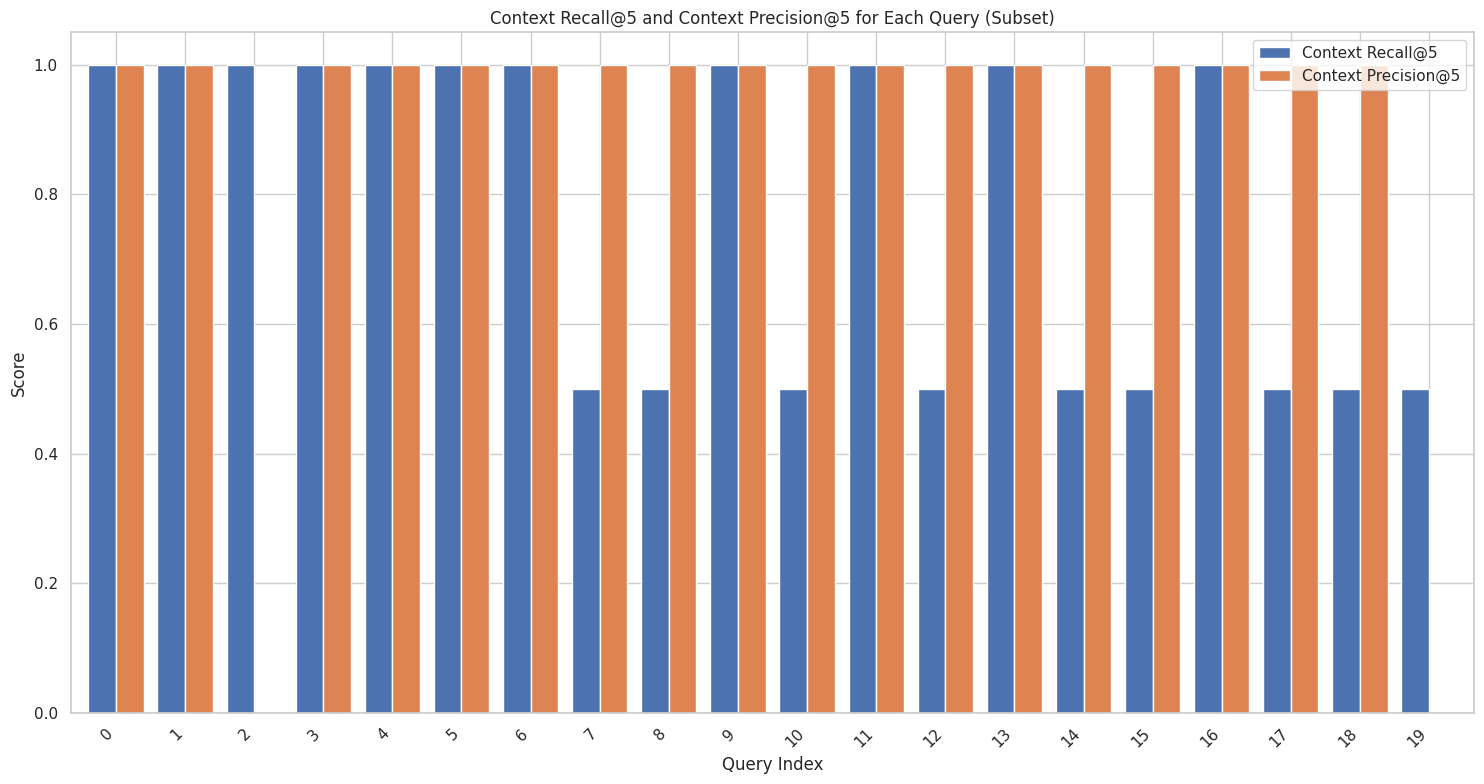

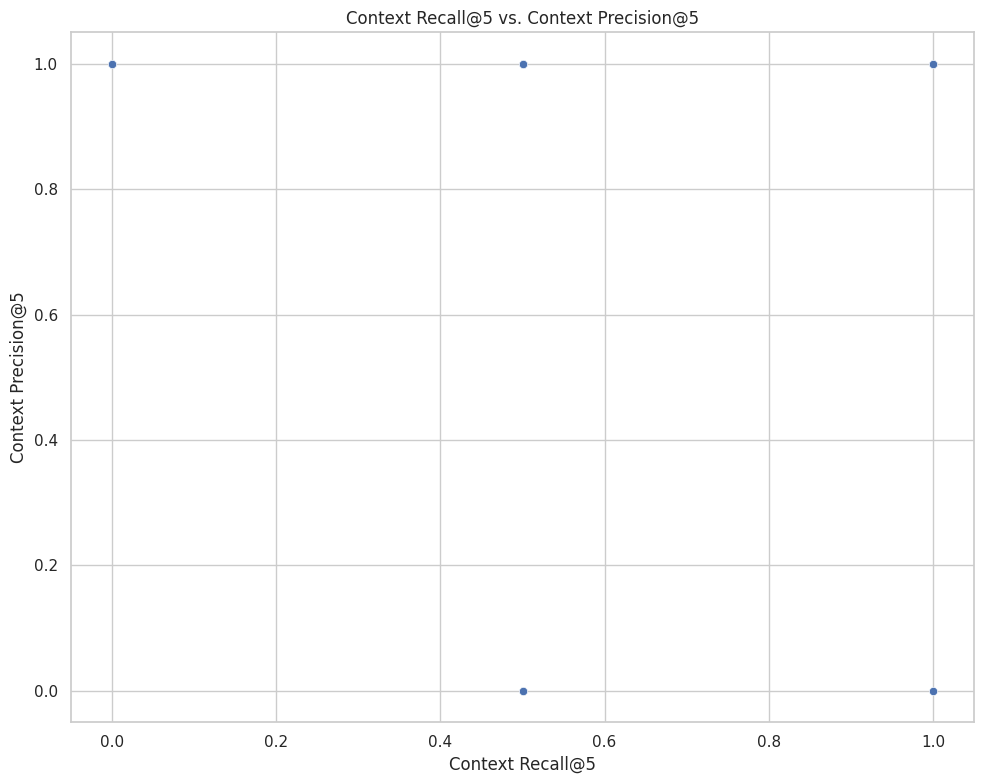

In [38]:
combined_df = recall_df.copy()
combined_df['context_precision'] = precision_df['context_precision']

plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")

# Bar plot for context recall and precision (this is for the first 20 queries only)
subset_df = combined_df.head(20)
subset_df.plot(kind='bar', figsize=(15, 8), width=0.8)
plt.title('Context Recall@5 and Context Precision@5 for Each Query (Subset)')
plt.xlabel('Query Index')
plt.ylabel('Score')
plt.xticks(rotation=45, ha="right")
plt.legend(['Context Recall@5', 'Context Precision@5'])
plt.tight_layout()
plt.show()

# Alt viz: Scatter plot for recall vs. precision
plt.figure(figsize=(10, 8))
sns.scatterplot(x='context_recall', y='context_precision', data=combined_df)
plt.title('Context Recall@5 vs. Context Precision@5')
plt.xlabel('Context Recall@5')
plt.ylabel('Context Precision@5')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
def calculate_recall_at_5(row):
    retrieved = set(row['retrieved_contexts'])
    relevant = set(row['relevant_contexts'])
    return len(retrieved & relevant) / len(relevant)

def calculate_precision_at_5(row):
    retrieved = set(row['retrieved_contexts'])
    relevant = set(row['relevant_contexts'])
    return len(retrieved & relevant) / len(retrieved)

data['Context_Recall@5'] = data.apply(calculate_recall_at_5, axis=1)
data['Context_Precision@5'] = data.apply(calculate_precision_at_5, axis=1)

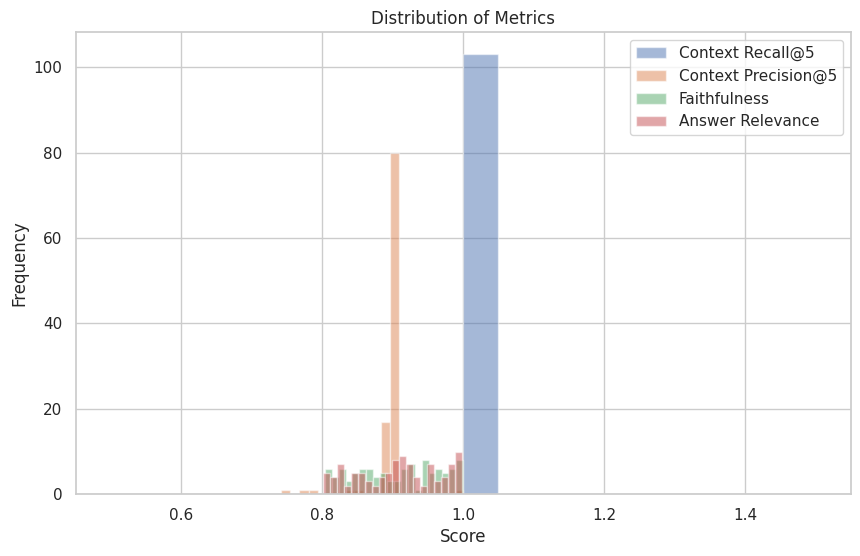

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(data['Context_Recall@5'], bins=20, alpha=0.5, label='Context Recall@5')
plt.hist(data['Context_Precision@5'], bins=20, alpha=0.5, label='Context Precision@5')
plt.hist(data['faithfulness'], bins=20, alpha=0.5, label='Faithfulness')
plt.hist(data['answer_relevance'], bins=20, alpha=0.5, label='Answer Relevance')
plt.legend(loc='upper right')
plt.title('Distribution of Metrics')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Bias stuff

In [ ]:
def check_geographical_bias(response):
    biases = ['less desirable', 'sour taste', 'negative', 'poor quality']
    return any(bias in response.lower() for bias in biases)

df = pd.read_csv(data)

# Apply bias detection
df['Geographical_Bias'] = df['chatbot_response'].apply(check_geographical_bias)
bias_percentage = df['Geographical_Bias'].mean() * 100

print(f"Geographical Bias Percentage: {bias_percentage:.2f}%")
print(df[['user_query', 'chatbot_response', 'Geographical_Bias']])
